In [8]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from torchnlp.datasets import penn_treebank_dataset
import torch
from torch.utils.data import DataLoader
from rsm_samplers import ptb_pred_sequence_collate
from ptb import lang_util
from torchvision import datasets, transforms
import torch.nn.functional as F
import torchvision.utils as vutils
from torch.nn import CrossEntropyLoss, MSELoss
from importlib import reload 
from torch.utils.data import Sampler, BatchSampler
import rsm
from functools import reduce, partial
import matplotlib.pyplot as plt

In [5]:
reload(lang_util)
corpus = lang_util.Corpus('/Users/jgordon/nta/datasets/PTB')

print(corpus.read_out(corpus.train[:60]))

print(len(corpus.valid), len(corpus.test), len(corpus.train))

aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre <unk> N years old will join the board as a nonexecutive director nov. N <eos> mr. <unk> is chairman of <unk> n.v. the dutch publishing group <eos> rudolph <unk> N years old and former


In [6]:
def _repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(_repackage_hidden(v) for v in h)


In [122]:
import rsm_samplers
import rsm
from ptb import lang_util
reload(rsm_samplers)
reload(rsm)
reload(lang_util)

VISUAL = True
BS = 1
MB = 3
    
VS = 10000
EMB_DIM = 28
m=50
n=5
k=15
eps = [0.0, 0.5]
forget_mu = 0.02
k_winner_cells=1
N_LAYERS = 2
weight_sparsity = None

bwe = lang_util.BitwiseWordEmbedding()

model = rsm.RSMNet(n_layers=N_LAYERS,
                   m=m, 
                   n=n, d_in=EMB_DIM, 
                   d_out=EMB_DIM, 
                   embed_dim=EMB_DIM,
                   k=k, 
                   k_winner_cells=k_winner_cells, 
                   eps=eps, 
                   do_inhibition=False,
                   x_b_norm=True, boost_strat='col_boosting', 
                   forget_mu=forget_mu, 
                   weight_sparsity=weight_sparsity,
                   feedback=True,
                   visual_debug=VISUAL
)

collate_fn = partial(rsm_samplers.ptb_pred_sequence_collate, vector_dict=bwe.embedding_dict)

sampler = rsm_samplers.PTBSequenceSampler(corpus.train, batch_size=BS, max_batches=MB)
loader = DataLoader(corpus.train,
                       batch_sampler=sampler,
                       collate_fn=collate_fn)

criterion = MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

Created <RSMLayer m=50 n=5 k=15 d_in=28 eps=0.00 /> with 128378 trainable params
Created <RSMLayer m=50 n=5 k=15 d_in=250 eps=0.50 /> with 150800 trainable params
Created RSMNet with 2 layer(s)


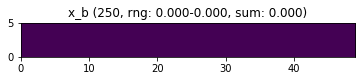

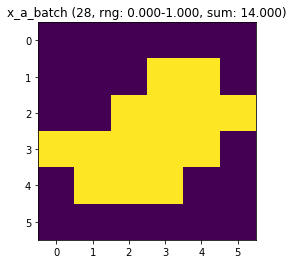

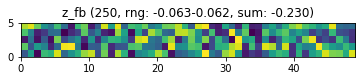

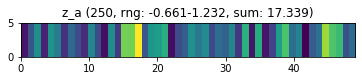

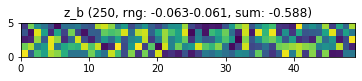

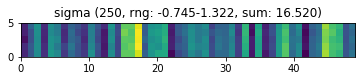

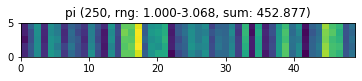

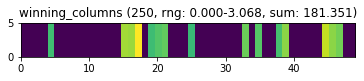

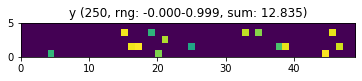

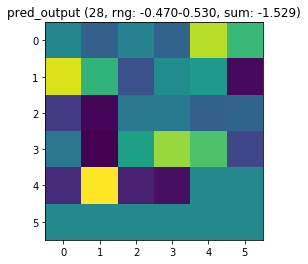

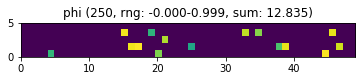

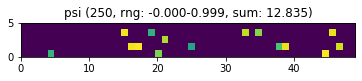

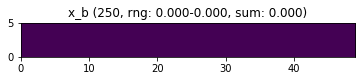

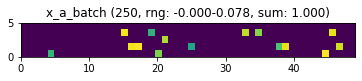

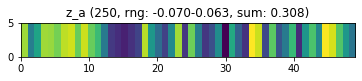

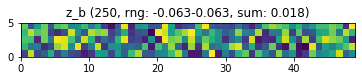

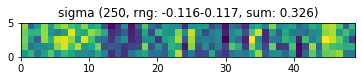

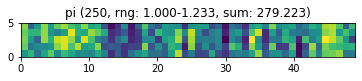

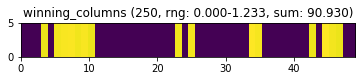

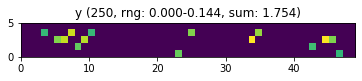

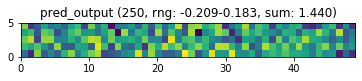

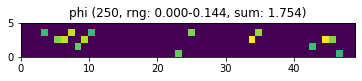

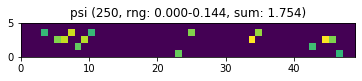

Finished batch 0


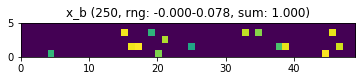

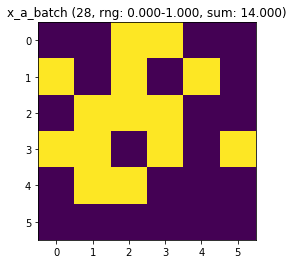

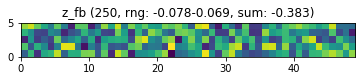

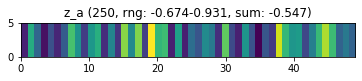

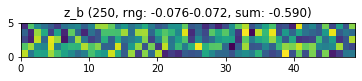

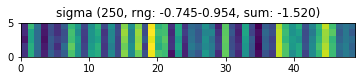

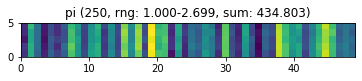

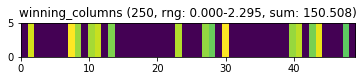

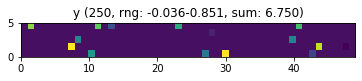

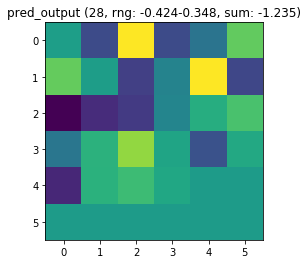

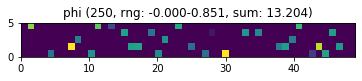

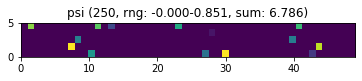

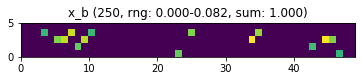

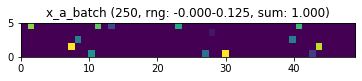

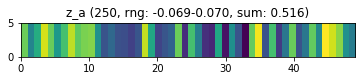

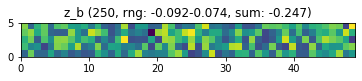

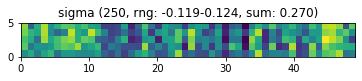

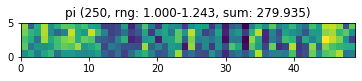

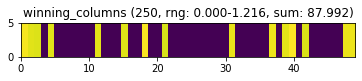

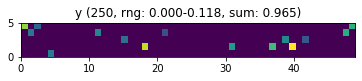

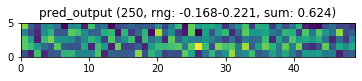

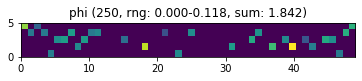

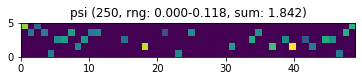

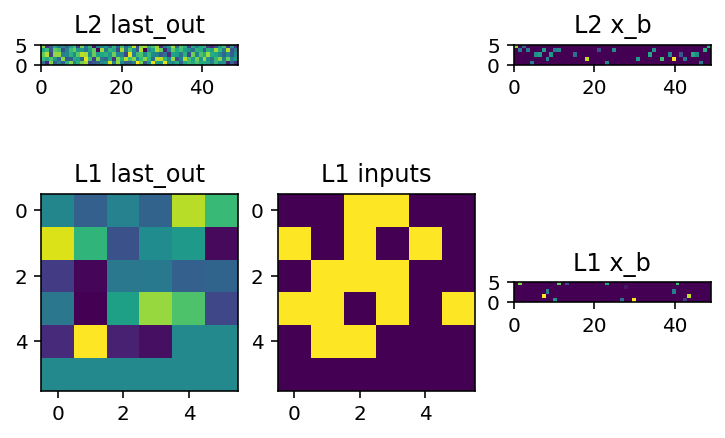

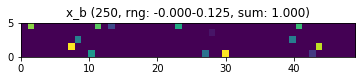

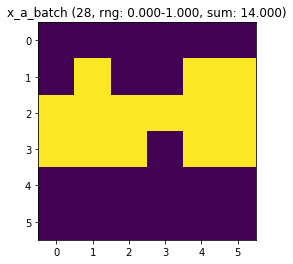

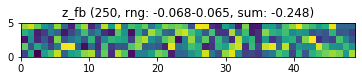

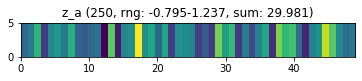

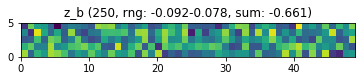

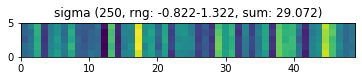

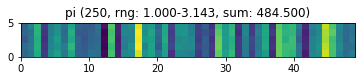

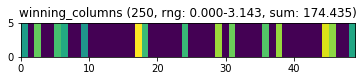

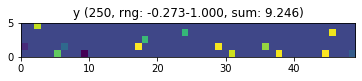

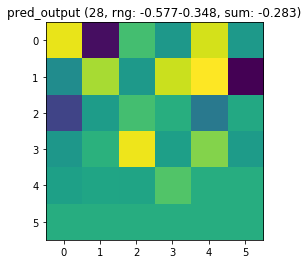

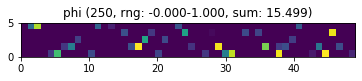

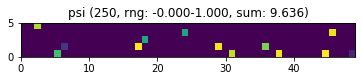

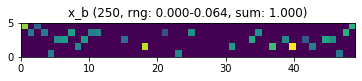

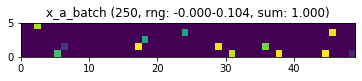

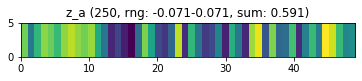

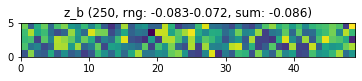

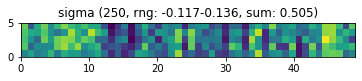

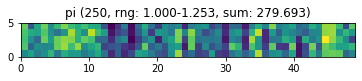

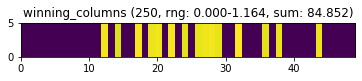

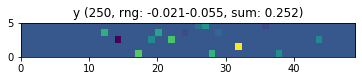

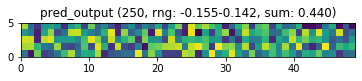

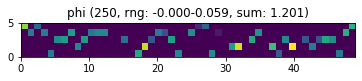

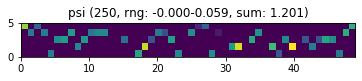

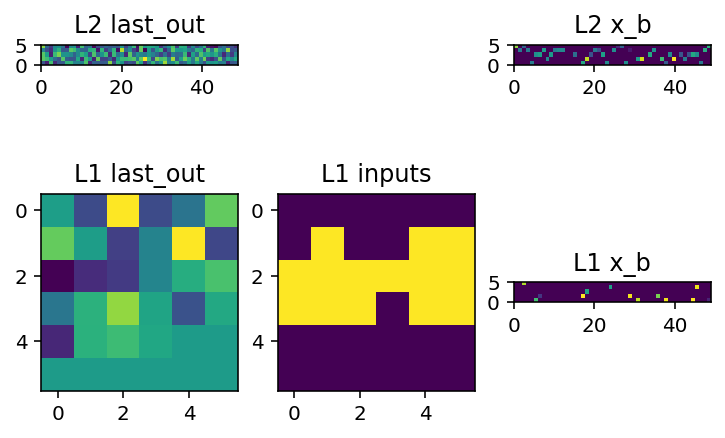

loss 1.255197823047638


In [123]:
hidden = model.init_hidden(BS)

EPOCHS = 1

for i in range(EPOCHS):
    total_loss = 0.0
    last_output = None
    for batch_id, (inputs, target, pred_target, pred_input) in enumerate(loader):
        out, hidden = model(inputs, hidden)
        
        if last_output is not None:
            # We need the prior output to calculate loss at layers i>0

            # First layer loss is between last image prediction and actual input image
            l1_loss = criterion(last_output[0], inputs.detach())
            # Layers > 1 loss is between last output (hidden predictions) and actual hidden
            ls_loss = criterion(torch.stack(last_output[1:]), hidden[0].detach())
            
            loss = l1_loss + ls_loss
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if last_output is not None:
            model._plot_tensors([
                ('last_out', last_output),
                ('inputs', [inputs.detach(), None]),
                ('x_b', hidden[0])
            ])
        
        hidden = _repackage_hidden(hidden)
        if batch_id % 100 == 0:
            print("Finished batch %d" % batch_id)
        
        last_output = out
        
    print('loss', total_loss)